# Importations

In [1]:
import gc ,random 
from ipywidgets import interact, fixed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 

import cv2
import SimpleITK as sitk
from PIL import Image

from sklearn import model_selection
from sklearn.model_selection import train_test_split

# utils functions 

In [3]:
def display(image_z, fixed):
    fig, axs = plt.subplots(figsize=(10,8))
    axs.imshow(sitk.GetArrayViewFromImage(fixed[:,:,image_z]), cmap='hot', interpolation='nearest');
    plt.show()

In [4]:
def display_images_with_Label(image_z , alpha , im_orginal , Label  ):
    fig, axs = plt.subplots(1,2,figsize=(20,8))
    im = (1-alpha) * im_orginal + alpha * (sitk.Cast(Label, sitk.sitkFloat32) )
    axs[0].imshow(sitk.GetArrayFromImage(im[:,:,image_z]),cmap=plt.cm.Greys_r);
    axs[1].imshow(sitk.GetArrayFromImage(sitk.LabelToRGB(Label)[:,:,image_z]));

In [5]:
def visualize_results(image_z   , label , label_hat): 
    fig, axs = plt.subplots(1,2,figsize=(20,8))

    axs[0].imshow(sitk.GetArrayFromImage(sitk.LabelToRGB(label)[:,:,image_z]));
    axs[0].set_title('Real mask')
  
    axs[1].imshow(sitk.GetArrayFromImage(sitk.LabelToRGB(label_hat)[:,:,image_z]));
    axs[1].set_title('predicted mask')

## hippocampus position probability Map  

![](https://nhoues.github.io/Segmentation-of-hippocampal/Images/XY_map%20.PNG)

![](https://nhoues.github.io/Segmentation-of-hippocampal/Images/XZ_map.PNG)

# Building a new DataBase

In [6]:
R_paths = [] 
L_paths = [] 
for i in range(1,26) :
    if i< 10 : 
        R_paths.append(f"../input/mri-images-part-1/HR Label/HR Label/s0{i}_hippolabels_hres_R_MNI.nii")
        L_paths.append(f"../input/mri-images-part-1/HR Label/HR Label/s0{i}_hippolabels_hres_L_MNI.nii")
    else : 
        R_paths.append(f"../input/mri-images-part-1/HR Label/HR Label/s{i}_hippolabels_hres_R_MNI.nii")
        L_paths.append(f"../input/mri-images-part-1/HR Label/HR Label/s{i}_hippolabels_hres_L_MNI.nii")

In [7]:
HR_path = []
for i in range(1,26) :
    if i< 10 : 
        HR_path.append(f"../input/mri-data-set/mri_dataset/s0{i}/s0{i}_t1w_hires_defaced_MNI.nii")
    elif i < 13 : 
        HR_path.append(f"../input/mri-data-set/mri_dataset/s{i}/s{i}_t1w_hires_defaced_MNI.nii")
    else : 
        HR_path.append(f"../input/mri-images-part-1/HR/HR/s{i}/s{i}_t1w_hires_defaced_MNI.nii")

In [8]:
LR_path = [] 
for i in range(1,26) :
    if i< 10 : 
        LR_path.append(f"../input/mri-images-part-1/MRI DATASET/MRI DATASET/s0{i}/s0{i}_t1w_standard_defaced_MNI.nii")
    else: 
        LR_path.append(f"../input/mri-images-part-1/MRI DATASET/MRI DATASET/s{i}/s{i}_t1w_standard_defaced_MNI.nii")


## Left hippocampal Croped images visualization

In [9]:
S1_HR =  sitk.ReadImage( HR_path[0] )
S1_LR =  sitk.ReadImage(LR_path[0] )
S1_LR = sitk.Resample(S1_LR, S1_HR)
S1_L_Label = sitk.ReadImage( L_paths[0] ,sitk.sitkInt8)

In [10]:
Crop_S1_L = S1_LR[126:226,190:340,90:250]
Crop_S1_Label_L = S1_L_Label[126:226,190:340,90:250]

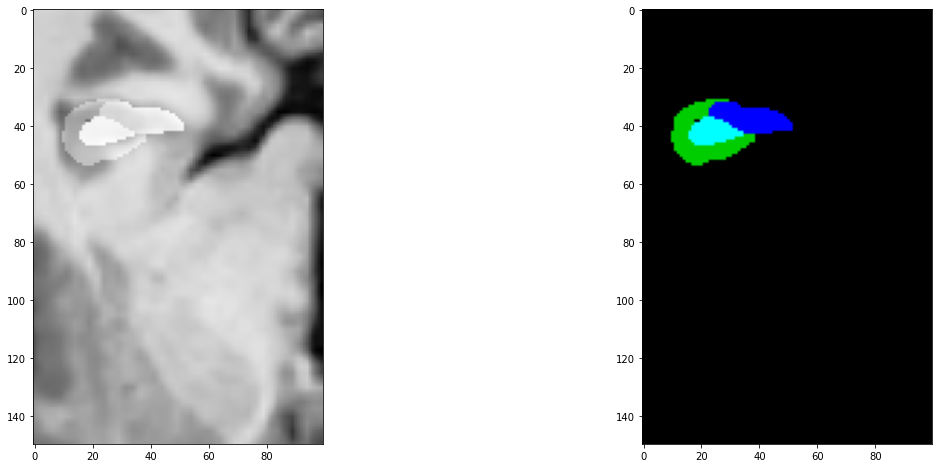

<function __main__.display_images_with_Label(image_z, alpha, im_orginal, Label)>

In [11]:
interact(display_images_with_Label, image_z=(0,Crop_S1_L.GetSize()[2] - 1),alpha = (0.9,1,0.005) , im_orginal = fixed(Crop_S1_L), Label=fixed(Crop_S1_Label_L))

## Building Left hippocampal Dataset

In [12]:
!mkdir all_data 
!mkdir all_data/HR_Left
!mkdir all_data/Mask_Left 
!mkdir all_data/LR_Left

In [13]:
for i in tqdm(range(len(HR_path)) ): 
   
    S1_HR =  sitk.ReadImage( HR_path[i] )
    S1_LR =  sitk.ReadImage( LR_path[i] )
    S1_LR =  sitk.Resample(S1_LR, S1_HR)
    
    S1_L_Label = sitk.ReadImage( L_paths[i] ,sitk.sitkInt8)[126:226,190:340,90:250]
    S1_LR = S1_LR[126:226,190:340,90:250]
    S1_HR = S1_HR[126:226,190:340,90:250]
   
    writer = sitk.ImageFileWriter()
    writer.SetFileName(f'all_data/HR_Left/S{i+1}_HR_Left.nii')
    writer.Execute(S1_HR)
    
    writer = sitk.ImageFileWriter()
    writer.SetFileName(f'all_data/LR_Left/S{i+1}_LR_Left.nii')
    writer.Execute(S1_LR)
    
    writer = sitk.ImageFileWriter()
    writer.SetFileName(f'all_data/Mask_Left/S{i+1}_Mask_Left.nii')
    writer.Execute(S1_L_Label)

In [14]:
gc.collect()

4652

## Right hippocampal Croped images visualization

In [15]:
S1_HR =  sitk.ReadImage( HR_path[0] )
S1_LR =  sitk.ReadImage(LR_path[0] )
S1_LR = sitk.Resample(S1_LR, S1_HR)
S1_R_Label = sitk.ReadImage( R_paths[0] ,sitk.sitkInt8)

Crop_S1_R = S1_LR[226:326,190:340,90:250]
Crop_S1_Label_R = S1_R_Label[226:326,190:340,90:250]

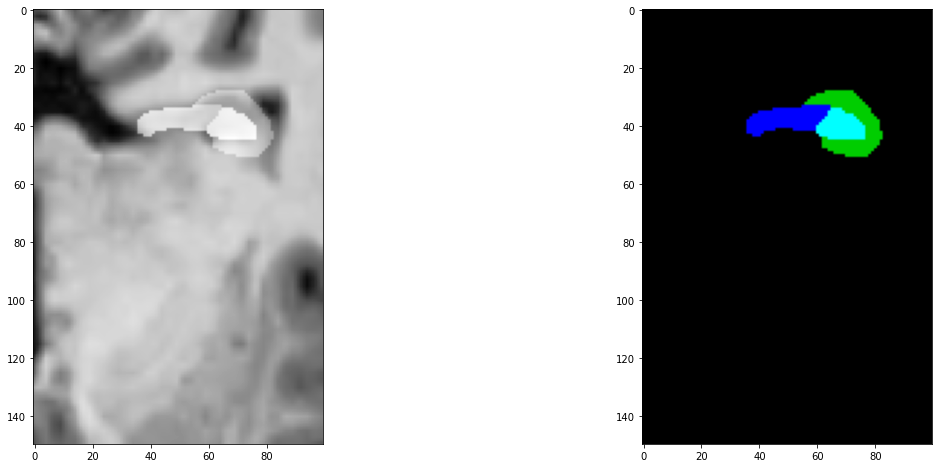

<function __main__.display_images_with_Label(image_z, alpha, im_orginal, Label)>

In [16]:
interact(display_images_with_Label, image_z=(0,Crop_S1_R.GetSize()[2] - 1),alpha = (0.9,1,0.005) , im_orginal = fixed(Crop_S1_R), Label=fixed(Crop_S1_Label_R))

## Building Right hippocampal Dataset

In [17]:
!mkdir all_data/HR_right
!mkdir all_data/Mask_right
!mkdir all_data/LR_right

In [18]:
for i in tqdm(range(len(HR_path)) ): 
   
    S1_HR =  sitk.ReadImage( HR_path[i] )
    S1_LR =  sitk.ReadImage( LR_path[i] )
    S1_LR =  sitk.Resample(S1_LR, S1_HR)
    
    S1_R_Label = sitk.ReadImage( R_paths[i] ,sitk.sitkInt8)[226:326,190:340,90:250]
    S1_LR = S1_LR[226:326,190:340,90:250]
    S1_HR = S1_HR[226:326,190:340,90:250]
   
    writer = sitk.ImageFileWriter()
    writer.SetFileName(f'all_data/HR_right/S{i+1}_HR_right.nii')
    writer.Execute(S1_HR)
    
    writer = sitk.ImageFileWriter()
    writer.SetFileName(f'all_data/LR_right/S{i+1}_LR_right.nii')
    writer.Execute(S1_LR)
    
    writer = sitk.ImageFileWriter()
    writer.SetFileName(f'all_data/Mask_right/S{i+1}_Mask_Right.nii')
    writer.Execute(S1_R_Label)

# 5-FOLDS SUBJECTS SPLITTING 

In [2]:
subjects = pd.DataFrame() 
subjects['HR_Left_path']  = [f'input/hippocampal-croped-mri/all_data/HR_Left/S{i}_HR_Left.nii' for i in range(1,26)]
subjects['HR_Right_path'] = [f'input/hippocampal-croped-mri/all_data/HR_right/S{i}_HR_right.nii' for i in range(1,26)]

subjects['HRL_L_path']    = [f'input/hippocampal-croped-mri/all_data/Mask_Left/S{i}_Mask_Left.nii' for i in range(1,26)] 
subjects['HRR_L_path']    = [f'input/hippocampal-croped-mri/all_data/Mask_right/S{i}_Mask_Right.nii' for i in range(1,26)]

subjects['LR_Left_path']  = [f'input/hippocampal-croped-mri/all_data/LR_Left/S{i}_LR_Left.nii' for i in range(1,26)]
subjects['LR_Right_path'] = [f'input/hippocampal-croped-mri/all_data/LR_right/S{i}_LR_right.nii' for i in range(1,26)]


subjects['Subject_num'] = [ i for i in range(1,26) ]
subjects.head()

,HR_Left_path,HR_Right_path,HRL_L_path,HRR_L_path,LR_Left_path,LR_Right_path,Subject_num
0,input/hippocampal-croped-mri/all_data/HR_Left/...,input/hippocampal-croped-mri/all_data/HR_right...,input/hippocampal-croped-mri/all_data/Mask_Lef...,input/hippocampal-croped-mri/all_data/Mask_rig...,input/hippocampal-croped-mri/all_data/LR_Left/...,input/hippocampal-croped-mri/all_data/LR_right...,1
1,input/hippocampal-croped-mri/all_data/HR_Left/...,input/hippocampal-croped-mri/all_data/HR_right...,input/hippocampal-croped-mri/all_data/Mask_Lef...,input/hippocampal-croped-mri/all_data/Mask_rig...,input/hippocampal-croped-mri/all_data/LR_Left/...,input/hippocampal-croped-mri/all_data/LR_right...,2
2,input/hippocampal-croped-mri/all_data/HR_Left/...,input/hippocampal-croped-mri/all_data/HR_right...,input/hippocampal-croped-mri/all_data/Mask_Lef...,input/hippocampal-croped-mri/all_data/Mask_rig...,input/hippocampal-croped-mri/all_data/LR_Left/...,input/hippocampal-croped-mri/all_data/LR_right...,3
3,input/hippocampal-croped-mri/all_data/HR_Left/...,input/hippocampal-croped-mri/all_data/HR_right...,input/hippocampal-croped-mri/all_data/Mask_Lef...,input/hippocampal-croped-mri/all_data/Mask_rig...,input/hippocampal-croped-mri/all_data/LR_Left/...,input/hippocampal-croped-mri/all_data/LR_right...,4
4,input/hippocampal-croped-mri/all_data/HR_Left/...,input/hippocampal-croped-mri/all_data/HR_right...,input/hippocampal-croped-mri/all_data/Mask_Lef...,input/hippocampal-croped-mri/all_data/Mask_rig...,input/hippocampal-croped-mri/all_data/LR_Left/...,input/hippocampal-croped-mri/all_data/LR_right...,5


In [5]:
example = sitk.ReadImage('input/hippocampal-croped-mri/all_data/Mask_Left/S10_Mask_Left.nii') 
n = example.GetSize()[2]-1
print('number of slice is ', n )
data = subjects.copy() 
data['slice'] = 0 
for i in tqdm(range(1,n))  : 
    x = subjects.copy() 
    x['slice'] =i 
    data = data.append(x)
print('number of slice  in the DataFrame  is' , data['slice'].nunique())
data.head()


number of slice is  159



number of slice  in the DataFrame  is 159


,HR_Left_path,HR_Right_path,HRL_L_path,HRR_L_path,LR_Left_path,LR_Right_path,Subject_num,slice
0,input/hippocampal-croped-mri/all_data/HR_Left/...,input/hippocampal-croped-mri/all_data/HR_right...,input/hippocampal-croped-mri/all_data/Mask_Lef...,input/hippocampal-croped-mri/all_data/Mask_rig...,input/hippocampal-croped-mri/all_data/LR_Left/...,input/hippocampal-croped-mri/all_data/LR_right...,1,0
1,input/hippocampal-croped-mri/all_data/HR_Left/...,input/hippocampal-croped-mri/all_data/HR_right...,input/hippocampal-croped-mri/all_data/Mask_Lef...,input/hippocampal-croped-mri/all_data/Mask_rig...,input/hippocampal-croped-mri/all_data/LR_Left/...,input/hippocampal-croped-mri/all_data/LR_right...,2,0
2,input/hippocampal-croped-mri/all_data/HR_Left/...,input/hippocampal-croped-mri/all_data/HR_right...,input/hippocampal-croped-mri/all_data/Mask_Lef...,input/hippocampal-croped-mri/all_data/Mask_rig...,input/hippocampal-croped-mri/all_data/LR_Left/...,input/hippocampal-croped-mri/all_data/LR_right...,3,0
3,input/hippocampal-croped-mri/all_data/HR_Left/...,input/hippocampal-croped-mri/all_data/HR_right...,input/hippocampal-croped-mri/all_data/Mask_Lef...,input/hippocampal-croped-mri/all_data/Mask_rig...,input/hippocampal-croped-mri/all_data/LR_Left/...,input/hippocampal-croped-mri/all_data/LR_right...,4,0
4,input/hippocampal-croped-mri/all_data/HR_Left/...,input/hippocampal-croped-mri/all_data/HR_right...,input/hippocampal-croped-mri/all_data/Mask_Lef...,input/hippocampal-croped-mri/all_data/Mask_rig...,input/hippocampal-croped-mri/all_data/LR_Left/...,input/hippocampal-croped-mri/all_data/LR_right...,5,0


In [6]:
all_subjects =  [ i for i in range(1,26) ]
data["kfold"] = -1    
data = data.sample(frac=1).reset_index(drop=True)

subjects = pd.DataFrame()
subjects['subjects'] = all_subjects
subjects = subjects.sample(frac=1).reset_index(drop=True)

kf = model_selection.KFold(n_splits=5)

for f, (t_, v_) in enumerate(kf.split(X=subjects)):
    print('fold subjects ',f,' ', subjects.loc[v_,'subjects'].values)
    index =  data[data['Subject_num'].isin(subjects.loc[v_,'subjects'].values)].index
    data.loc[index,'kfold'] = f

fold subjects  0   [ 9  5 10 23 18]
fold subjects  1   [ 1 16 22  2  8]
fold subjects  2   [11 14 12 21 15]
fold subjects  3   [25  6 24 17  4]
fold subjects  4   [19 20 13  7  3]


In [7]:
data.to_csv('data_5fold.csv')